In [1]:
#Importando Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
!pip install xgboost
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')


## Carregar o conjunto de dados

In [2]:
# Carregue o dataset Telco Customer Churn diretamente da fonte online
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

In [3]:
# Verifique se o dataframe foi carregado corretamente
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Pré-processamento e Análise Inicial

In [4]:
#Verificando valores ausentes e tipos de dados
print("\nValores ausentes:", df.isnull().sum().sum())
print("\nTipos de dados:")
print(df.dtypes)



Valores ausentes: 0

Tipos de dados:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [5]:
# Converter TotalCharges para numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

In [6]:
# Remover a coluna customerID (não relevante para a modelagem)
df.drop('customerID', axis=1, inplace=True)

In [7]:
# Converter a variável alvo para valores numéricos
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [8]:
# Identificando colunas categóricas e numéricas
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(exclude=['object']).columns.tolist()
numerical_cols.remove('Churn')  # Removendo a variável alvo

print("\nDistribuição de Churn:")
print(df['Churn'].value_counts())
print(f"Taxa de Churn: {df['Churn'].mean():.2%}")


Distribuição de Churn:
Churn
0    5174
1    1869
Name: count, dtype: int64
Taxa de Churn: 26.54%


## Visualizações Principais

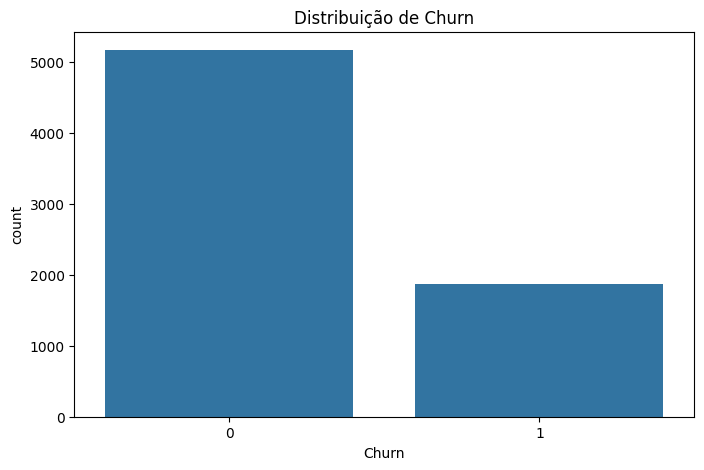

In [9]:
# 1. Distribuição de Churn
plt.figure(figsize=(8, 5))
sns.countplot(x='Churn', data=df)
plt.title('Distribuição de Churn')
plt.show()

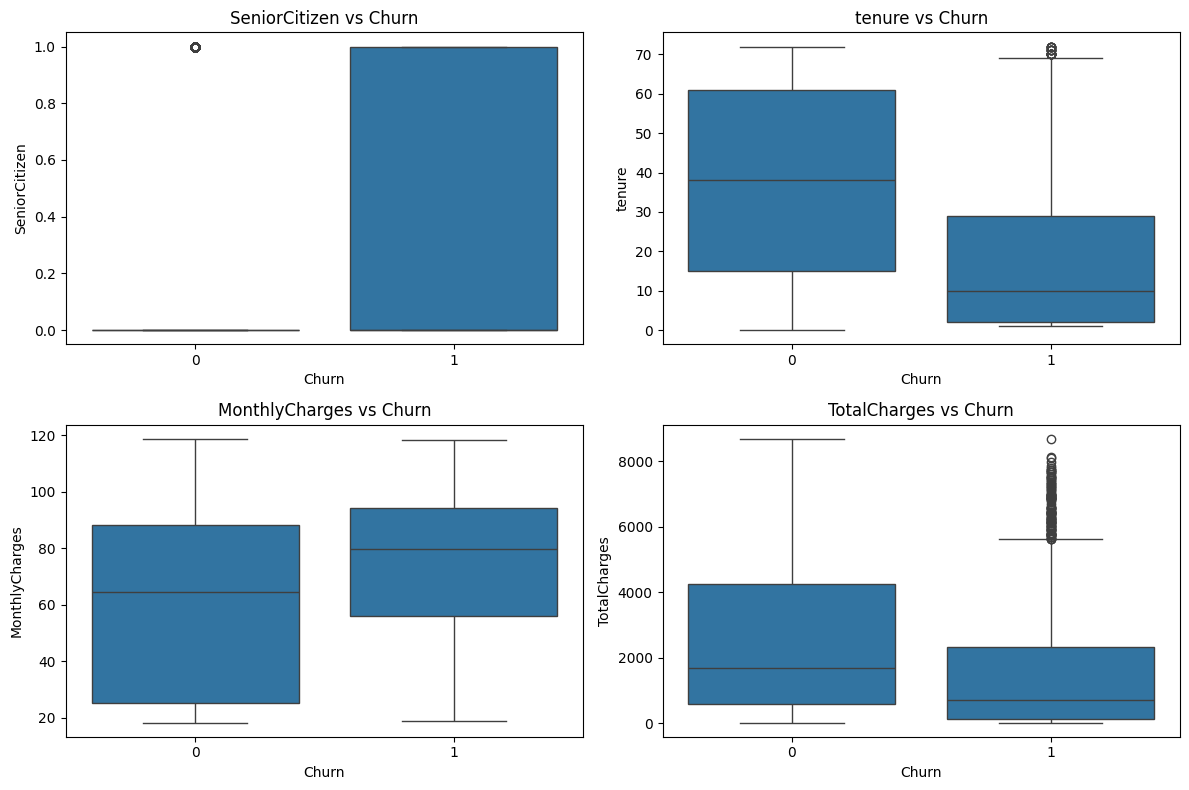

In [10]:
# 2. Variáveis numéricas vs Churn
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} vs Churn')
plt.tight_layout()
plt.show()

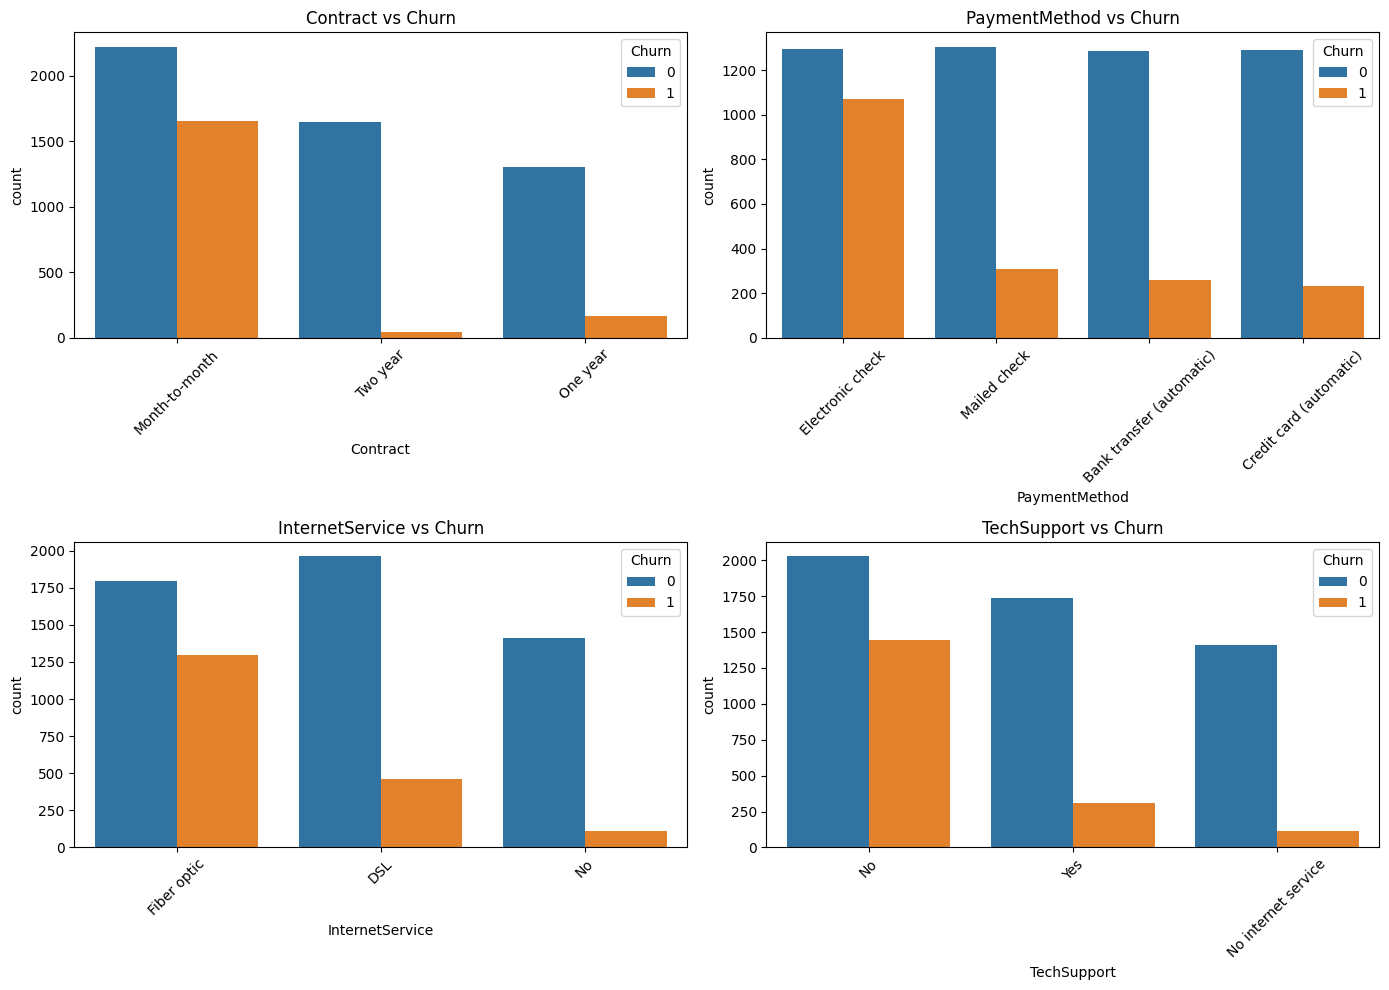

In [11]:
# 3. Principais variáveis categóricas vs Churn
important_cat_cols = ['Contract', 'PaymentMethod', 'InternetService', 'TechSupport']
plt.figure(figsize=(14, 10))
for i, col in enumerate(important_cat_cols):
    plt.subplot(2, 2, i+1)
    order = df[col].value_counts().index
    sns.countplot(x=col, hue='Churn', data=df, order=order)
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

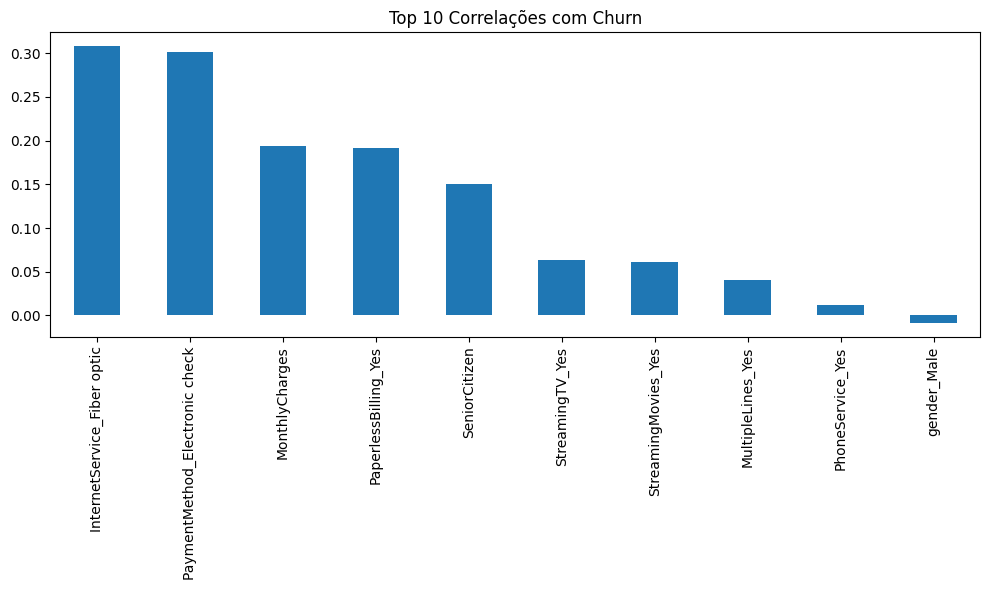


Top 10 correlações com Churn:
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
MonthlyCharges                    0.193356
PaperlessBilling_Yes              0.191825
SeniorCitizen                     0.150889
StreamingTV_Yes                   0.063228
StreamingMovies_Yes               0.061382
MultipleLines_Yes                 0.040102
PhoneService_Yes                  0.011942
gender_Male                      -0.008612
Name: Churn, dtype: float64


In [12]:
# 4. Correlação com a variável alvo
# Convertendo variáveis categóricas para análise de correlação
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
correlations = df_encoded.corr()['Churn'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
correlations[1:11].plot(kind='bar')
plt.title('Top 10 Correlações com Churn')
plt.tight_layout()
plt.show()

print("\nTop 10 correlações com Churn:")
print(correlations[1:11])

## 4. Preparação para Modelagem

In [13]:
# Dividindo os dados em conjuntos de treino e teste
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Atualizando identificação de colunas após a divisão
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

In [15]:
# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

## 5. Função de Avaliação de Modelos

In [16]:
# Função de Avaliação de Modelos
def evaluate_model(model, X_test, y_test, model_name):
    """
    Avalia um modelo de classificação e exibe suas métricas e matriz de confusão.

    Parâmetros:
    model: Modelo treinado para avaliação
    X_test: Features do conjunto de teste
    y_test: Labels verdadeiros do conjunto de teste
    model_name: Nome do modelo para exibição
    """
    # Previsões
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    # Métricas (MOVED INSIDE THE FUNCTION)
    metrics = {
        'Acurácia': accuracy_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

    print(f"\n--- {model_name} ---")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Matriz de confusão (ALREADY INSIDE THE FUNCTION)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Sem Churn', 'Com Churn'],
               yticklabels=['Sem Churn', 'Com Churn'])
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

    return metrics, y_pred, y_prob

In [17]:
# Dicionário para armazenar os modelos e resultados
models = {
    'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000),
    'Árvore de Decisão': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

models = {
    'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000),
    'Árvore de Decisão': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Estrutura para armazenar resultados
results_metrics = []
model_names = []

for name, classifier in models.items():
    # Criando e treinando o pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    print(f"\nTreinando {name}...")
    pipeline.fit(X_train, y_train)


Treinando Regressão Logística...

Treinando Árvore de Decisão...

Treinando Random Forest...

Treinando XGBoost...



--- XGBoost ---
Acurácia: 0.7864
Precisão: 0.6109
Recall: 0.5374
F1-Score: 0.5718


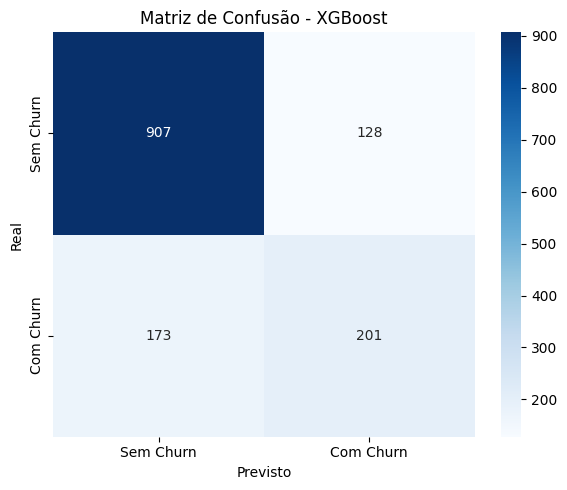

In [18]:
# Avaliando o modelo
metrics, y_pred, y_prob = evaluate_model(pipeline, X_test, y_test, name)

In [19]:
# Armazenando os resultados corretamente
results_metrics.append(metrics)
model_names.append(name)

In [20]:
# Criar um DataFrame estruturado adequadamente para comparação
comparison_df = pd.DataFrame(results_metrics)
comparison_df['Modelo'] = model_names
comparison_df = comparison_df.set_index('Modelo')

print("\nComparação de Modelos:")
print(comparison_df)


Comparação de Modelos:
         Acurácia  Precisão    Recall  F1-Score
Modelo                                         
XGBoost  0.786373  0.610942  0.537433  0.571835


<Figure size 1200x600 with 0 Axes>

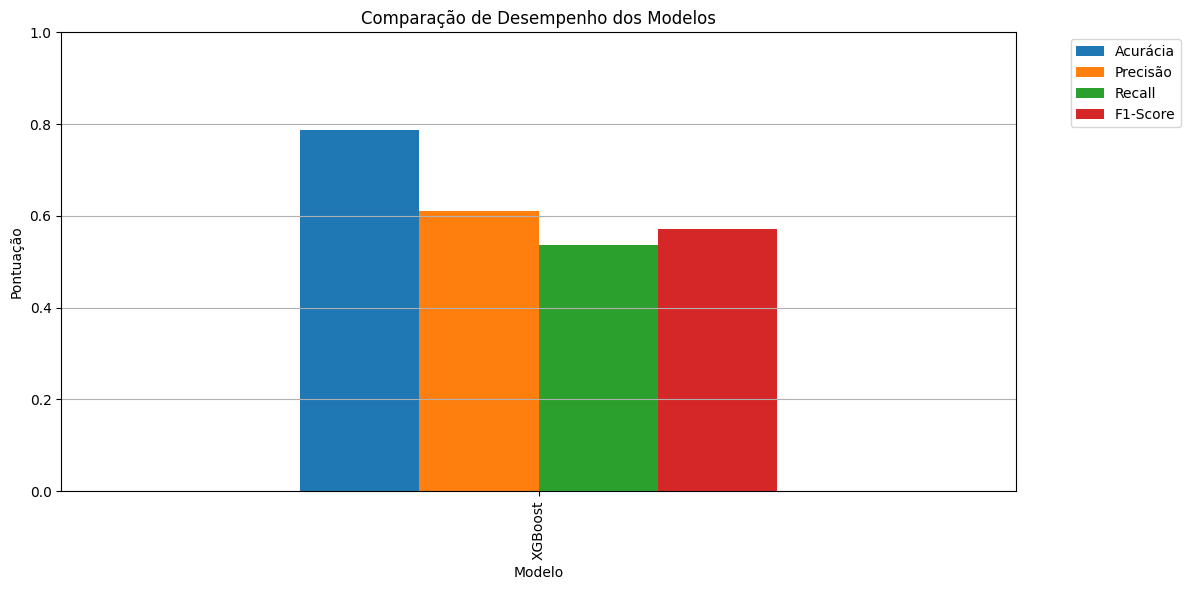

In [21]:
# Visualização comparativa corrigida
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title('Comparação de Desempenho dos Modelos')
plt.ylabel('Pontuação')
plt.ylim(0, 1.0)
plt.grid(axis='y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

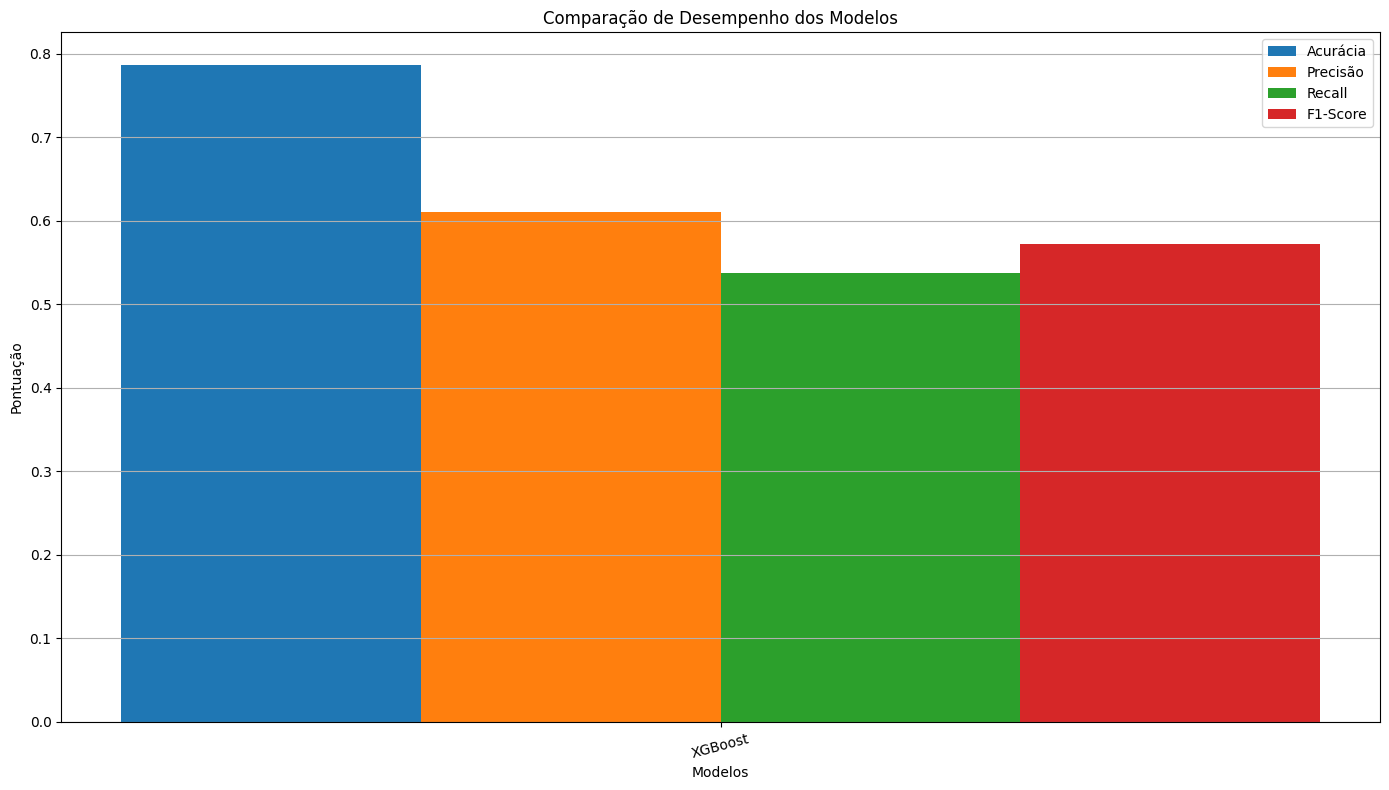

In [22]:
# Visualização de barras para comparação mais clara
plt.figure(figsize=(14, 8))
metrics = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
x = np.arange(len(model_names))
width = 0.2

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, comparison_df[metric], width=width, label=metric)

plt.xlabel('Modelos')
plt.ylabel('Pontuação')
plt.title('Comparação de Desempenho dos Modelos')
plt.xticks(x + width*1.5, model_names, rotation=15)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [23]:
# Identificando o melhor modelo com base no F1-Score
best_model_idx = comparison_df['F1-Score'].idxmax()
print(f"\nMelhor modelo com base no F1-Score: {best_model_idx}")
print(f"F1-Score: {comparison_df.loc[best_model_idx, 'F1-Score']:.4f}")


Melhor modelo com base no F1-Score: XGBoost
F1-Score: 0.5718


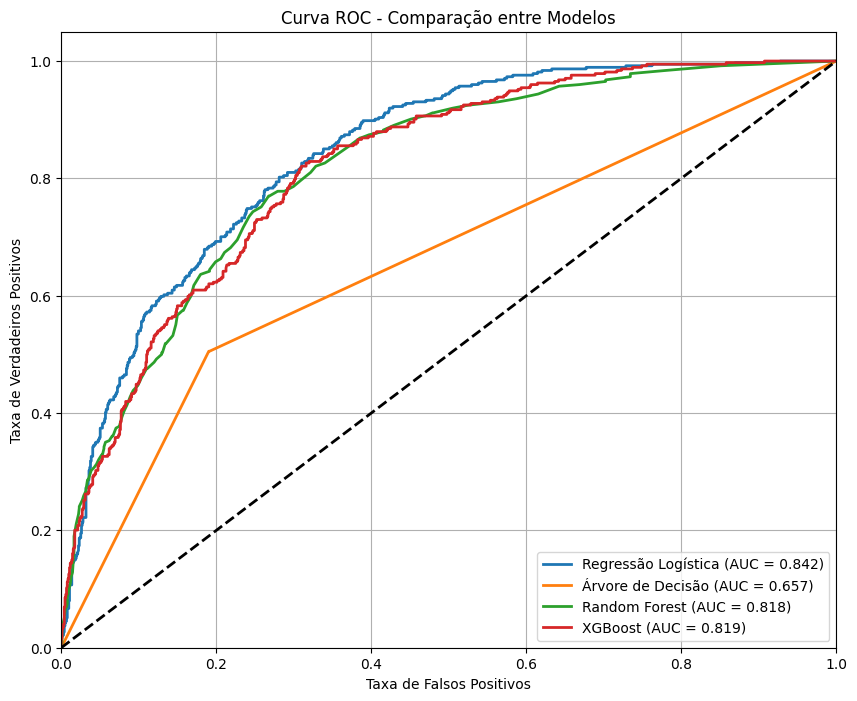

In [24]:
# Adicionando curva ROC para comparação
plt.figure(figsize=(10, 8))
for name, classifier in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    if hasattr(pipeline, "predict_proba"):
        y_score = pipeline.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Comparação entre Modelos')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [25]:
# Salvar o melhor modelo
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', models[best_model_idx])
])
best_pipeline.fit(X_train, y_train)
joblib.dump(best_pipeline, 'best_churn_model.pkl')
print(f"\nMelhor modelo ({best_model_idx}) salvo como 'best_churn_model.pkl'")


Melhor modelo (XGBoost) salvo como 'best_churn_model.pkl'


In [26]:
# Analisando recursos mais importantes (para modelos que suportam feature_importances_)
if hasattr(models[best_model_idx], 'feature_importances_'):
    # Treinando o modelo de melhor desempenho
    best_model = models[best_model_idx]
    # Ajustar o pré-processador aos dados para obter nomes das colunas transformadas
    preprocessor.fit(X_train)

In [27]:
# Obter nomes das colunas após one-hot encoding
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numerical_cols, cat_features])

In [28]:
# Treinando o pipeline completo com o melhor modelo
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', models[best_model_idx])
])
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Streamin...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [29]:
# Ajustar o pré-processador separadamente para obter os nomes das features
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['gender', 'Partner', 'Dependents',
                                  'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])

In [30]:
# Obter nomes das colunas após one-hot encoding
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numerical_cols, cat_features])

In [31]:
# Para o XGBoost, precisamos treinar o modelo diretamente nas features transformadas
X_train_transformed = preprocessor.transform(X_train)

In [32]:
# Criar uma nova instância do mesmo tipo de modelo
best_model_direct = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [33]:
# Treinar o modelo direto nas features transformadas
best_model_direct.fit(X_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [34]:
# Agora podemos acessar as feature importances com segurança
importances = best_model_direct.feature_importances_
indices = np.argsort(importances)[::-1]

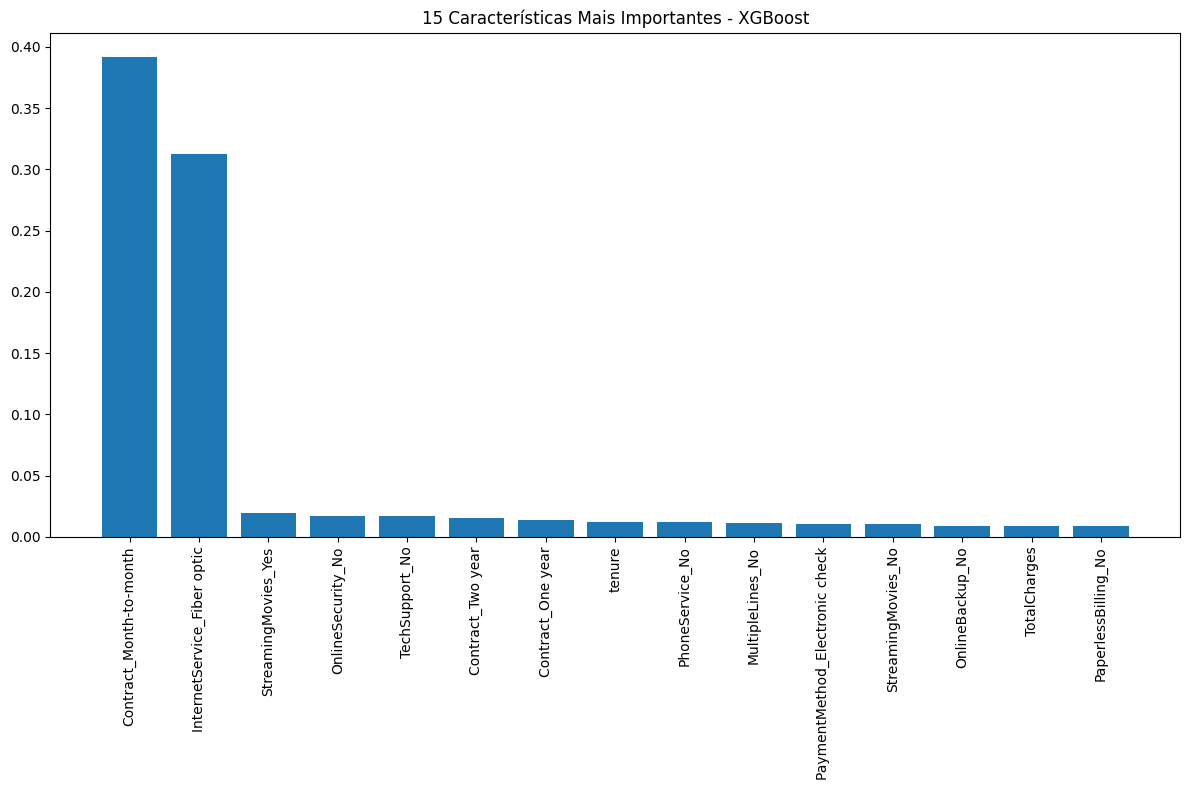


15 Características Mais Importantes:
Contract_Month-to-month: 0.3919
InternetService_Fiber optic: 0.3122
StreamingMovies_Yes: 0.0197
OnlineSecurity_No: 0.0170
TechSupport_No: 0.0166
Contract_Two year: 0.0157
Contract_One year: 0.0140
tenure: 0.0121
PhoneService_No: 0.0117
MultipleLines_No: 0.0109
PaymentMethod_Electronic check: 0.0103
StreamingMovies_No: 0.0102
OnlineBackup_No: 0.0089
TotalCharges: 0.0088
PaperlessBilling_No: 0.0087


In [35]:
# Exibir os 15 recursos mais importantes
plt.figure(figsize=(12, 8))
plt.title(f'15 Características Mais Importantes - {best_model_idx}')
plt.bar(range(15), importances[indices][:15], align='center')
plt.xticks(range(15), [str(feature_names[i]) for i in indices[:15]], rotation=90)
plt.tight_layout()
plt.show()

print("\n15 Características Mais Importantes:")
for i in range(15):
    print(f"{feature_names[indices][i]}: {importances[indices][i]:.4f}")

In [39]:
# Salvando o modelo otimizado
joblib.dump(best_pipeline, 'churn_prediction_model.pkl')
print("\nModelo salvo como 'churn_prediction_model.pkl'")


Modelo salvo como 'churn_prediction_model.pkl'


In [41]:
# Demonstração rápida de uso do modelo
loaded_model = joblib.load('churn_prediction_model.pkl')
y_pred_loaded = loaded_model.predict(X_test)
print(f"\nAcurácia do modelo carregado: {accuracy_score(y_test, y_pred_loaded):.4f}")
print("\nProjeto de Previsão de Churn de Clientes concluído!")


Acurácia do modelo carregado: 0.7864

Projeto de Previsão de Churn de Clientes concluído!
